# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, make_scorer

pd.set_option("max_columns", 50)
plt.style.use('seaborn-dark')
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Step 1:  clean the data

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
profile.head(3)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN


In [4]:
transcript.head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [5]:
def clean_portfolio(portfolio):
    '''
    Function to do the necessary cleaning to the portfolio dataframe
    
    Args:
    portfolio (dataframe) - Dataframe to be cleaned
    
    Returns:
    portfolio (dataframe) - cleaned dataframe
    
    '''
    cleaned_portfolio = portfolio.copy()
    
    # Make channels columns binary
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
       
    # One hot encoding for offer_type column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # drop the channels and offer_type column
    cleaned_portfolio.drop(['channels'], axis=1, inplace=True)
           
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    
    # change the duration from day to hour
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
       
    return cleaned_portfolio

In [6]:
cleaned_portfolio = clean_portfolio(portfolio)

In [7]:
cleaned_portfolio.head(3)

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1


In [8]:
def clean_profile(profile):
    '''
    Function to do the necessary cleaning to the profile dataframe
    
    Args:
    profile (dataframe) - Profile dataframe
    
    Returns:
    profile (dataframe) - Cleaned profile dataframe
    
    '''
    profile_clean = profile.copy()
        
    # Transform date from int to datetime
    date = lambda x: pd.to_datetime(str(x), format='%Y%m%d')
    profile_clean.became_member_on = profile_clean.became_member_on.apply(date)
    
    # the number of days since the user is a memeber of starbucks
    profile_clean['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile_clean['memberdays'] = pd.to_numeric(profile_clean['memberdays'].dt.days, downcast='integer')
    
    # Create column that separates customers with valid data
    profile_clean['valid'] = (profile_clean.age != 118).astype(int)
    
    # Change the name of id column to customer_id
    profile_clean.rename(columns={'id':'customer_id'}, inplace=True)
    
    #fill nan values for gender
    profile_clean['gender'] = profile_clean.fillna('Not_provided')
    
    # Create dummy columns for the gender column
    dummy_gender = pd.get_dummies(profile_clean.gender, prefix="gender")
    profile_clean = pd.concat([profile_clean, dummy_gender], axis=1, sort=False)
    
    profile_clean['age'].fillna(profile_clean['age'].mean(), inplace=True)
    profile_clean['income'].fillna(profile_clean['income'].mean(), inplace=True)
    
    
    return profile_clean
    
   

In [9]:
cleaned_profile = clean_profile(profile)

In [10]:
cleaned_profile.head(3)

,gender,age,customer_id,became_member_on,income,memberdays,valid,gender_F,gender_M,gender_Not_provided,gender_O
0,Not_provided,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,1547,0,0,0,1,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.000000,1394,1,1,0,0,0
2,Not_provided,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.991568,1032,0,0,0,1,0


In [11]:
def clean_transcript(transcript):
    '''
    Function to do the necessary cleaning to the profile dataframe
    
    Args:
    transcript (dataframe) - the transcript dataframe to be cleaned
    
    Returns:
    offer (dataframe) - the cleaned transcript dataframe
    
    '''
    # extract the rows that are related to offer action
    cleaned_transcript = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # extract the offer id from value column
    cleaned_transcript['offer_id'] = cleaned_transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return cleaned_transcript


In [12]:
cleaned_transcript = clean_transcript(transcript)

<ipython-input-11-41bd242a9a27>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_transcript['offer_id'] = cleaned_transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])


In [13]:
cleaned_transcript.head(3)

,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5


In [47]:
#Some data Preparation steps

# merging the data in the dataframe we will be working on
df = pd.merge(cleaned_transcript, cleaned_profile, left_on='person', right_on= 'customer_id',how="left")
df = pd.merge(df, cleaned_portfolio, left_on='offer_id', right_on= 'id',how="left")

# drop duplicated columns from merge and value columns also
df.drop(columns=['value','customer_id','id'],axis = 1,inplace=True)
df.rename({'person':'customer_id'},axis=1, inplace= True)

# Transform object dtypes into category
cat_list = df.select_dtypes(include=object).columns.to_list()
df[cat_list] = df[cat_list].astype("category")

## change offer id to a more readable code
offer_id = {'ae264e3637204a6fb9bb56bc8210ddfd': 'O_1',
                '4d5c57ea9a6940dd891ad53e9dbe8da0': 'O_2',
                '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'O_3',
                'f19421c1d4aa40978ebb69ca19b0e20d': 'O_4',
                '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'O_5',
                '2298d6c36e964ae4a3e7e9706d1fb8c2': 'O_6',
                'fafdcd668e3743c1bb461111dcafc2a4': 'O_7',
                '2906b810c7d4411798c6938adc9daaa5': 'O_8',
                '3f207df678b143eea3cee63160fa8bed': 'O_9',
                '5a8bc65990b245e5a138643cd4eb9837': 'O_10'}
    
df.offer_id = df.offer_id.apply(lambda x: offer_id[x] if x else None)

# making income categories
income_bins = np.linspace(30000,120000,10)
df['income_cat'] = pd.cut(df['income'], income_bins)

# making age categories
age_bins = np.arange(18,119,10)
df['age_cat'] = pd.cut(df['age'], age_bins)

# making memberdays categories
memberdays_bins = np.arange(1016,2840,120)
df['memberdays_cat'] = pd.cut(df['memberdays'], memberdays_bins)

# OneHotEncoding offer_id and event
dummy_event = pd.get_dummies(df.event, prefix="event")
df = pd.concat([df, dummy_event], axis=1, sort=False)

dummy_offer_id = pd.get_dummies(df.offer_id, prefix="offer")
df = pd.concat([df, dummy_offer_id], axis=1, sort=False)


df.head(3)

,customer_id,event,time,offer_id,gender,age,became_member_on,income,memberdays,valid,gender_F,gender_M,gender_Not_provided,gender_O,reward,difficulty,duration,offer_type,web,email,mobile,social,bogo,discount,informational,income_cat,age_cat,memberdays_cat,event_offer completed,event_offer received,event_offer viewed,offer_O_5,offer_O_6,offer_O_8,offer_O_9,offer_O_2,offer_O_10,offer_O_3,offer_O_1,offer_O_4,offer_O_7
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,O_3,F,75,2017-05-09,100000.000000,1461,1,1,0,0,0,5,5,168,bogo,1,1,1,0,1,0,0,"(90000.0, 100000.0]","(68, 78]","(1376, 1496]",0,1,0,0,0,0,0,0,0,1,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,O_5,Not_provided,118,2017-08-04,65404.991568,1374,0,0,0,1,0,5,20,240,discount,1,1,0,0,0,1,0,"(60000.0, 70000.0]","(108, 118]","(1256, 1376]",0,1,0,1,0,0,0,0,0,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,O_8,M,68,2018-04-26,70000.000000,1109,1,0,1,0,0,2,10,168,discount,1,1,1,0,0,1,0,"(60000.0, 70000.0]","(58, 68]","(1016, 1136]",0,1,0,0,0,1,0,0,0,0,0,0,0


# Step 2: explore the data

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 41 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   customer_id            167581 non-null  category      
 1   event                  167581 non-null  category      
 2   time                   167581 non-null  int64         
 3   offer_id               167581 non-null  category      
 4   gender                 167581 non-null  category      
 5   age                    167581 non-null  int64         
 6   became_member_on       167581 non-null  datetime64[ns]
 7   income                 167581 non-null  float64       
 8   memberdays             167581 non-null  int16         
 9   valid                  167581 non-null  int32         
 10  gender_F               167581 non-null  uint8         
 11  gender_M               167581 non-null  uint8         
 12  gender_Not_provided    167581 non-null  uint

### Exploring the categorical data first

In [16]:
print(df.customer_id.nunique())
print(df.event.nunique())
print(df.offer_id.nunique())
print(df.gender.nunique())

16994
3
10
4


#### Next: Let's plot customer_id counting distribution and event, offer_id, gender counting

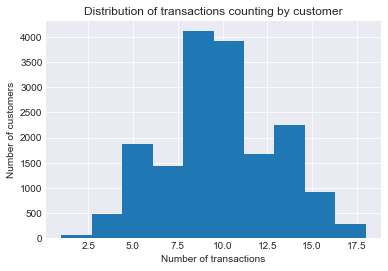

In [17]:
df.groupby('customer_id')['event'].count().hist()
plt.title('Distribution of transactions counting by customer')
plt.xlabel('Number of transactions')
plt.ylabel('Number of customers')
plt.show()

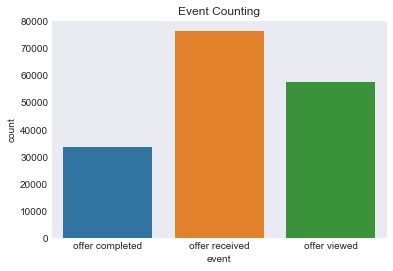

In [18]:
sns.countplot(df.event)
plt.title('Event Counting')
plt.show()

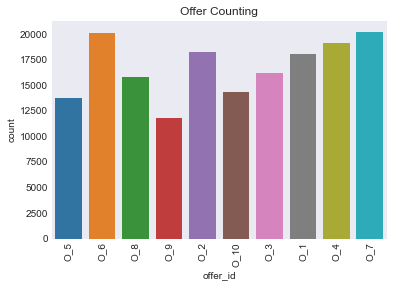

In [19]:
g = sns.countplot(df.offer_id)
plt.xticks(rotation=90)
plt.title('Offer Counting')
plt.show()

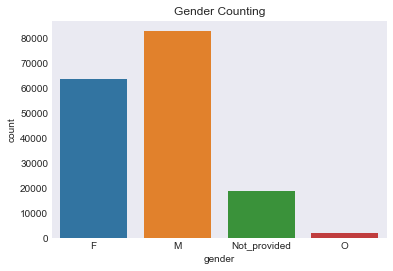

In [49]:
g = sns.countplot(df.gender)
plt.title('Gender Counting')
plt.show()

### Explore numeric atributes
* In all the notebook the 118 invalid age was left as is, so take that into consideration.

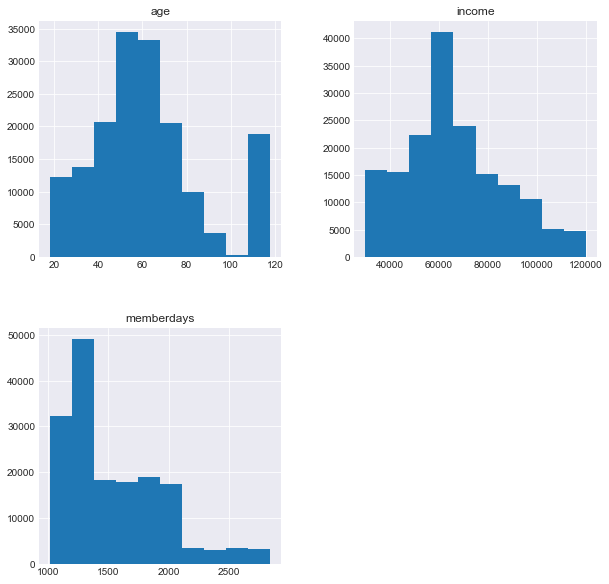

In [21]:
df[['age','memberdays','income']].hist(figsize=(10,10))
plt.show()

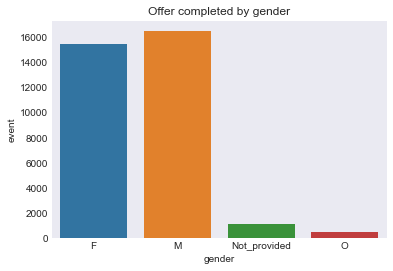

In [22]:
# Offer completed by gender
data = df[df['event'] == 'offer completed'].groupby('gender')['event'].count()
sns.barplot(x=data.index,y=data)
plt.title('Offer completed by gender')
plt.show()

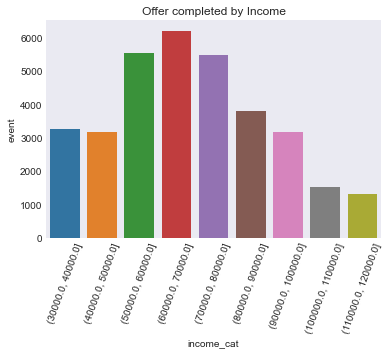

In [23]:
data = df[df['event'] == 'offer completed'].groupby('income_cat')['event'].count()
sns.barplot(x=data.index,y=data)
plt.title('Offer completed by Income')
plt.xticks(rotation=70)
plt.show()

Counting of completed offers isn't that informative if we don't know the number of offers received, next we plot the proportion of offer_completed by offer_received

In [24]:
def plot_proportion(df, col):
    '''
    Helper function to plot offer completed for offer received proportion on the data frame
    
    Args:
    df (dataframe): our working dataframe
    col (str): string of col name wanted
            
    '''
        
    dff = pd.DataFrame()
    dff['completed'] = df[df['event'] == 'offer completed'].groupby(col)['event'].count()
    dff['received'] = df[df['event'] == 'offer received'].groupby(col)['event'].count()
    dff['proportion'] = dff['completed'] / dff['received']
    
    sns.barplot(x=dff.index,y=dff['proportion'])
    plt.grid()
    
    
    

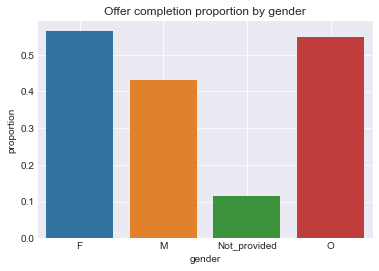

In [25]:
plot_proportion(df ,'gender')
plt.title('Offer completion proportion by gender')
plt.show()


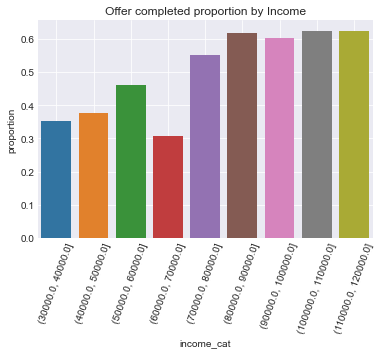

In [26]:
plot_proportion(df ,'income_cat')
plt.title('Offer completed proportion by Income')
plt.xticks(rotation=70)
plt.show()

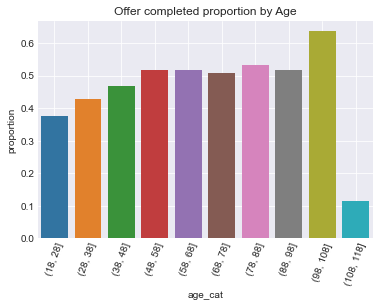

In [27]:
plot_proportion(df ,'age_cat')
plt.title('Offer completed proportion by Age')
plt.xticks(rotation=70)
plt.show()

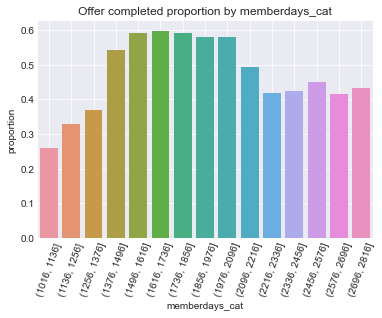

In [28]:
plot_proportion(df ,'memberdays_cat')
plt.title('Offer completed proportion by memberdays_cat')
plt.xticks(rotation=70)
plt.show()

Now let's plot the Offers' behavior for diferent categories

In [55]:
def plot_behavior(col):
    '''
    Helper function to plot behavior ompleted for offer received proportion on the data frame
    
    Args:
        col (str): working df col name provided as string
            
    '''
    
    dff = pd.DataFrame()
    dff['completed'] = df[df['event'] == 'offer completed'].groupby(['offer_id',col])['income'].count()
    dff['received'] = df[df['event'] == 'offer received'].groupby(['offer_id',col])['income'].count()
    dff['proportion'] = dff['completed'] / dff['received']
    dff = dff.proportion.unstack()
    dff = dff.drop(['O_9','O_10'])
    i = 0
    plt.figure(figsize=(10,7))
    for col in dff.columns:
        plt.plot(dff.iloc[:,i], label = col)
        i = i +1
    plt.legend()
    

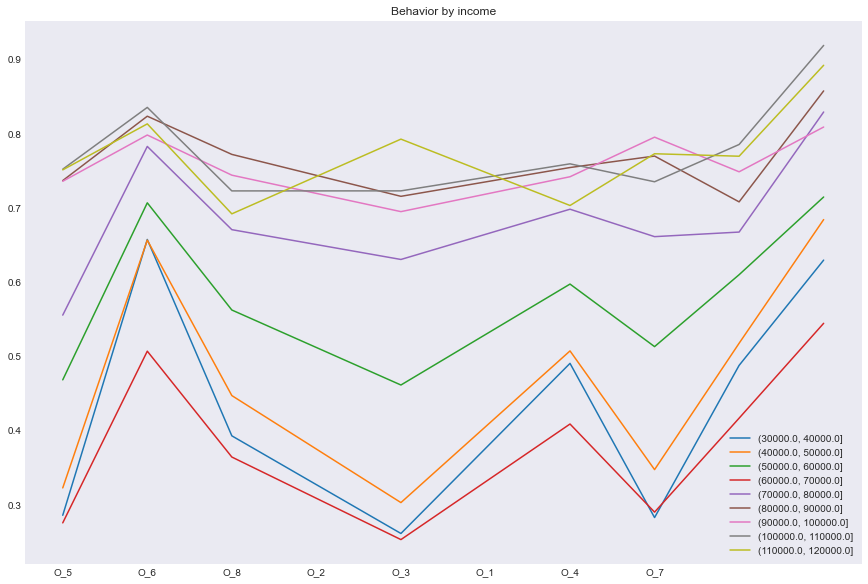

In [52]:
plot_behavior('income_cat')
plt.title('Behavior by income')
plt.show()

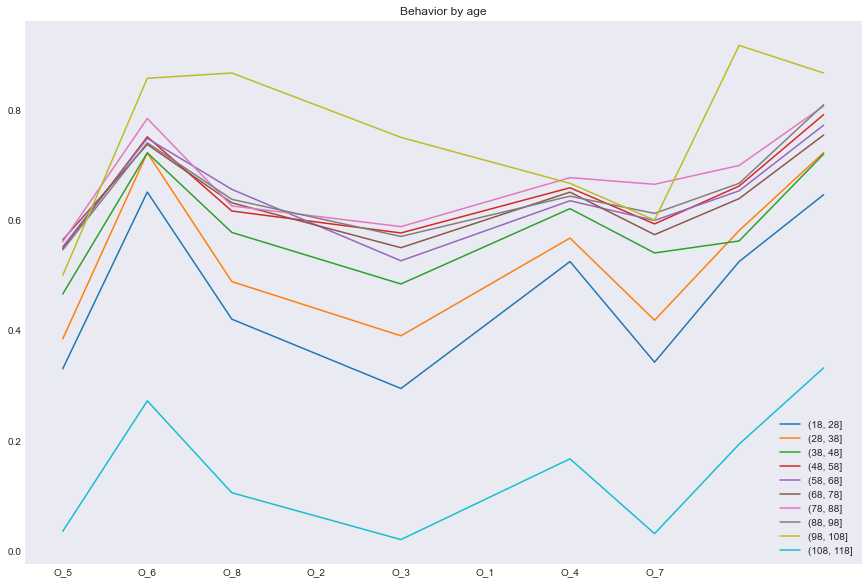

In [53]:
plot_behavior('age_cat')
plt.title('Behavior by age')
plt.show()

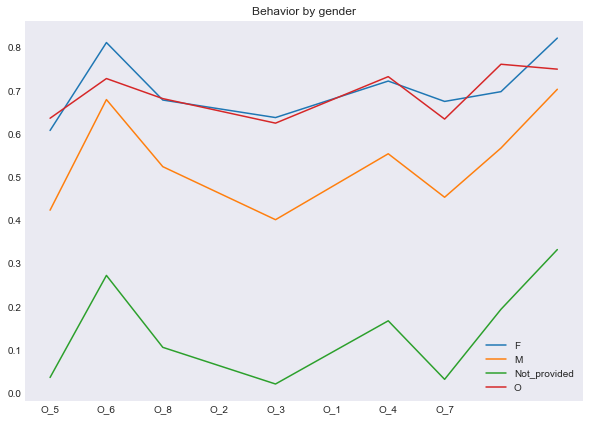

In [56]:
plot_behavior('gender')
plt.title('Behavior by gender')
plt.show()

We can see that the offer behavior don't change too much when we change personal characteristics

## Step 3: Data modeling
Problem: Classification problem where we want to know if a offer will be completed by a user based on user characteristics

Goal: predict if a offer will be completed by a customer
 
Metric: As it is a classification problem we will use a Accuracy to measure how well a model correctly predicts whether an offer is successful.

In [57]:
# Choose atributes to train the model
ml_columns = ['age','income','memberdays','valid','gender_F','gender_M', 'gender_Not_provided', 'gender_O','reward', 'difficulty',
       'duration', 'web', 'email', 'mobile', 'social', 'bogo',
       'discount', 'informational','offer_O_5', 'offer_O_6', 'offer_O_8', 'offer_O_9', 'offer_O_2',
       'offer_O_10', 'offer_O_3', 'offer_O_1', 'offer_O_4', 'offer_O_7']


In [58]:
# Get atributes and target
X = df[ml_columns]
y = df['event_offer completed']


In [37]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=10)

In [38]:
model = RandomForestClassifier()

# set scoring method so it giver more importance to the True Positives detection
scorer = make_scorer(fbeta_score, beta=40)

# Number of trees in random forest
n_estimators = [5,10, 30, 100, 150, 200, 250, 300]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(2, 11,2)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [10, 15, 20]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf}

rf_random1 = RandomizedSearchCV(estimator = model,
                                   param_distributions = random_grid,
                                   n_iter = 200,
                                   scoring= scorer,
                                   cv = 3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs = -1)

rf_random1.fit(X_train, y_train)

#recall

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 57.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 6, 8, 10, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [10, 15, 20],
                                        'n_estimators': [5, 10, 30, 100, 150,
                                                         200, 250, 300]},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=40),
                   verbose=2)

In [45]:
rf_random1.best_params_

{'n_estimators': 5,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None}

In [46]:
#y_pred1 = rf_random1.predict(X_test)
#a1 = pd.DataFrame()
#a1['pred'] = y_pred1
#a1['pred'].value_counts()

In [40]:
accuracy_score(y_test, y_pred1)

0.7152001735922752

Conclusion:

We sucessfully trained a RandomForestClassifier model with optimized hyperparameters with RandomSearch and also got a 71.52% accuracy metric which will certainly give the analysts some insight about the sucess of an offer before it is sent.
